In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io

In [91]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name = fn, length = len(uploaded[fn])))

Saving Gold.csv to Gold.csv
User uploaded file "Gold.csv" with length 412362 bytes


In [0]:
df = pd.read_csv("Gold.csv")

In [93]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6209,2020-05-17,1757.500000,1768.300049,1755.199951,1767.900024,1767.900024,714482.0
6210,2020-05-18,1771.000000,1775.800049,1729.300049,1736.500000,1736.500000,142944830.0
6211,2020-05-19,1740.199951,1751.599976,1727.199951,1749.000000,1749.000000,98019332.0
6212,2020-05-20,1754.900024,1757.599976,1744.000000,1749.699951,1749.699951,90999071.0
6213,2020-05-21,1742.099976,1744.800049,1715.300049,1725.300049,1725.300049,117665805.0


In [94]:
print(df.shape)

(6214, 7)


In [97]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [0]:
# Fill NAN or null value 

df["Open"].fillna( method ='ffill', inplace = True)
df["High"].fillna( method ='ffill', inplace = True)
df["Low"].fillna( method ='ffill', inplace = True)
df["Close"].fillna( method ='ffill', inplace = True)
df["Adj Close"].fillna( method ='ffill', inplace = True)
df["Volume"].fillna( method ='ffill', inplace = True)


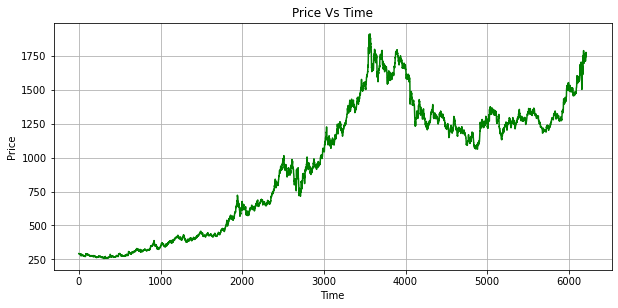

In [102]:
f, axs = plt.subplots(1, 1, figsize = (10, 10))

price = df["High"]

plt.subplot(212)
plt.grid(True)

plt.xlabel('Time')
plt.ylabel("Price")
plt.title('Price Vs Time')

plt.plot(price, 'g')

In [0]:
company_close = df.High.values.astype('float32')
company_close = company_close.reshape(-1, 1)
closing_stock = company_close

In [104]:
closing_stock[: , 0]

array([ 292.5,  292.4,  291.5, ..., 1751.6, 1757.6, 1744.8], dtype=float32)

In [105]:
stocks = closing_stock[: , 0]
print(stocks)
stocks = stocks.reshape(len(stocks) , 1)

[ 292.5  292.4  291.5 ... 1751.6 1757.6 1744.8]


In [0]:
#Feature scaling the vector for better model performance.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
stocks = scaler.fit_transform(stocks)

In [0]:
train = int(len(stocks) * 0.80)
test = len(stocks) - train

In [109]:
print(train, test)

4971 1243


In [110]:
train = stocks[ 0 : train]
print(train)

[[0.0219873 ]
 [0.02192689]
 [0.02138326]
 ...
 [0.5965569 ]
 [0.5913017 ]
 [0.5913017 ]]


In [0]:
test = stocks[len(train) : ]

In [0]:
train = train.reshape(len(train) , 1)
test = test.reshape(len(test) , 1)

In [115]:
print(train.shape , test.shape)

(4971, 1) (1243, 1)


In [0]:
# Process_data for the required input for LSTM.

def process_data(data , n_features):
    dataX, dataY = [], []
    for i in range(len(data) - n_features - 1):
        a = data[i : (i + n_features), 0]
        dataX.append(a)
        dataY.append(data[i + n_features, 0])
    return np.array(dataX), np.array(dataY)

In [0]:
#Here I am taking 2 past values to predict a single value. This has already been checked and optimized after taking several cases.

n_features = 2

trainX, trainY = process_data(train, n_features)
testX, testY = process_data(test, n_features)

In [118]:
len(testY)


1240

In [119]:
print(trainX.shape , trainY.shape , testX.shape , testY.shape)

(4968, 2) (4968,) (1240, 2) (1240,)


In [0]:
#Reshaping again for required LSTM input as (sample , timestamp , features per sample).

#Here I am taking timestamp as 1.

trainX = trainX.reshape(trainX.shape[0] , 1 ,trainX.shape[1])
testX = testX.reshape(testX.shape[0] , 1 ,testX.shape[1])

In [0]:
import math

from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation
from keras.layers import LSTM , GRU
from keras.optimizers import Adam , SGD , RMSprop

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [126]:
#Checkpointing the model when required and using other callbacks.

from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

filepath = "stock_weights.hdf5"

lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, epsilon = 0.0001, patience = 1, verbose = 1)
checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [127]:
# Build Model

model = Sequential()
model.add(GRU(512, input_shape = (1 , n_features) , return_sequences = True)) # previous 256
model.add(Dropout(0.4))
model.add(LSTM(512))                # previous 256
model.add(Dropout(0.4))
model.add(Dense(128, activation = 'relu')) # previous 64
model.add(Dense(1))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 1, 512)            791040    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,956,033
Trainable params: 2,956,033
Non-trainable params: 0
____________________________________________

In [0]:
# Compile Model

model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = 0.0005), metrics = ['mean_squared_error'])


In [129]:
# Run Model

history = model.fit(trainX, trainY, epochs = 100 , batch_size = 32, 
          callbacks = [checkpoint , lr_reduce] , validation_data = (testX, testY))

Train on 4968 samples, validate on 1240 samples
Epoch 1/100
4968/4968 [==============================] - 13s 3ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 9.8159e-05 - val_mean_squared_error: 9.8159e-05

Epoch 00001: val_loss improved from -inf to 0.00010, saving model to stock_weights.hdf5
Epoch 2/100
4968/4968 [==============================] - 11s 2ms/step - loss: 7.5826e-04 - mean_squared_error: 7.5826e-04 - val_loss: 4.5376e-04 - val_mean_squared_error: 4.5376e-04

Epoch 00002: val_loss improved from 0.00010 to 0.00045, saving model to stock_weights.hdf5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 3/100
4968/4968 [==============================] - 12s 2ms/step - loss: 7.3640e-04 - mean_squared_error: 7.3640e-04 - val_loss: 1.2605e-04 - val_mean_squared_error: 1.2605e-04

Epoch 00003: val_loss did not improve from 0.00045

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.
Epoch 4/100
4968/4

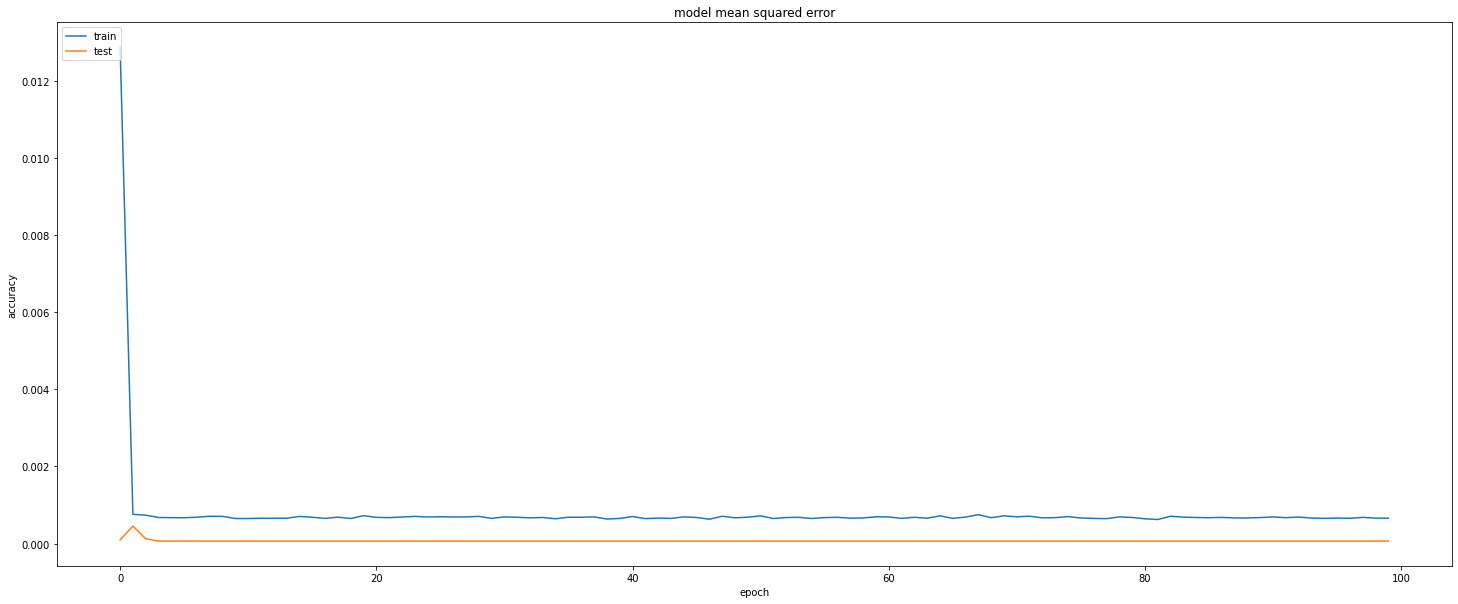

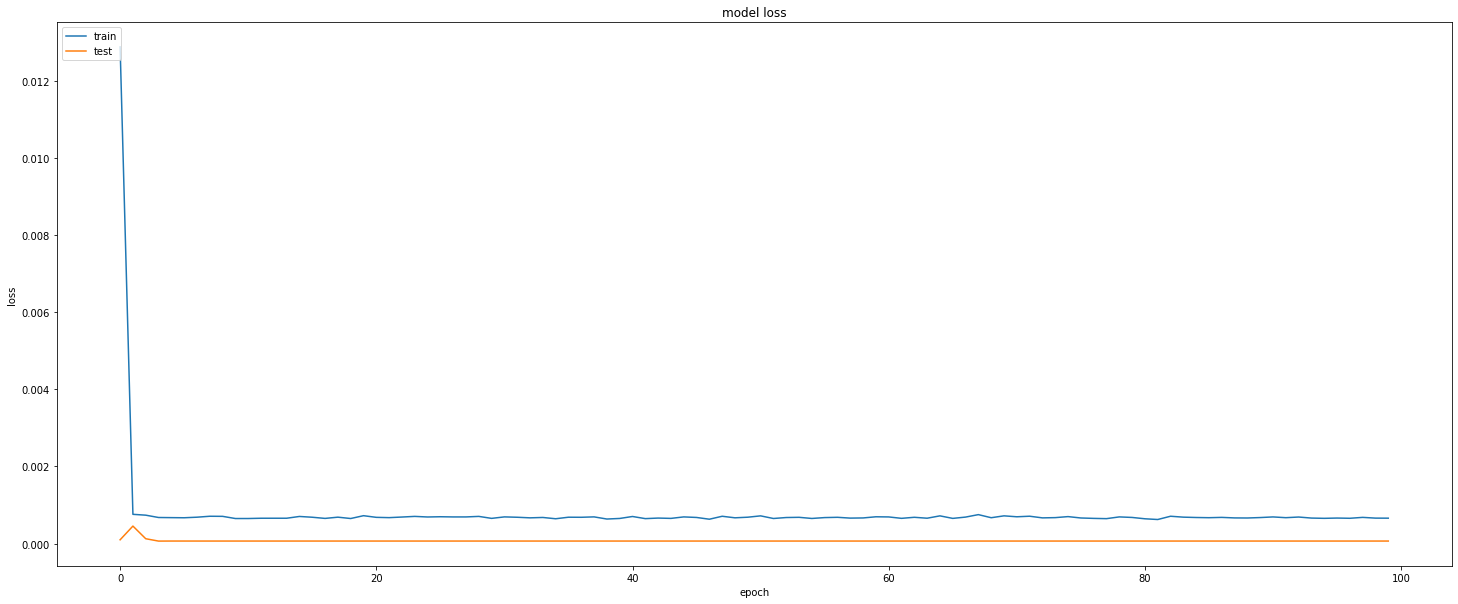

In [130]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [131]:
# The mean square error for validation set is 0.000174 which is very low and good as well.

def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

    return trainScore[0], testScore[0]

model_score(model, trainX, trainY , testX, testY)

Train Score: 0.00005 MSE (0.01 RMSE)
Test Score: 0.00007 MSE (0.01 RMSE)


(4.537367836357279e-05, 6.593184474284851e-05)

In [132]:
# Inverse transforming the scaled vector earlier and checking for the error visually in the graph

pred = model.predict(testX)
pred = scaler.inverse_transform(pred)
pred[:10]

array([[1245.6866],
       [1253.0006],
       [1260.2993],
       [1256.1727],
       [1245.394 ],
       [1241.5436],
       [1239.509 ],
       [1243.8038],
       [1256.8267],
       [1279.7462]], dtype=float32)

In [133]:
testY = testY.reshape(testY.shape[0] , 1)
testY = scaler.inverse_transform(testY)
testY[:10]

array([[1256.1],
       [1270.6],
       [1248.5],
       [1248.5],
       [1240.9],
       [1244.2],
       [1249.5],
       [1270.1],
       [1295.5],
       [1295.5]], dtype=float32)

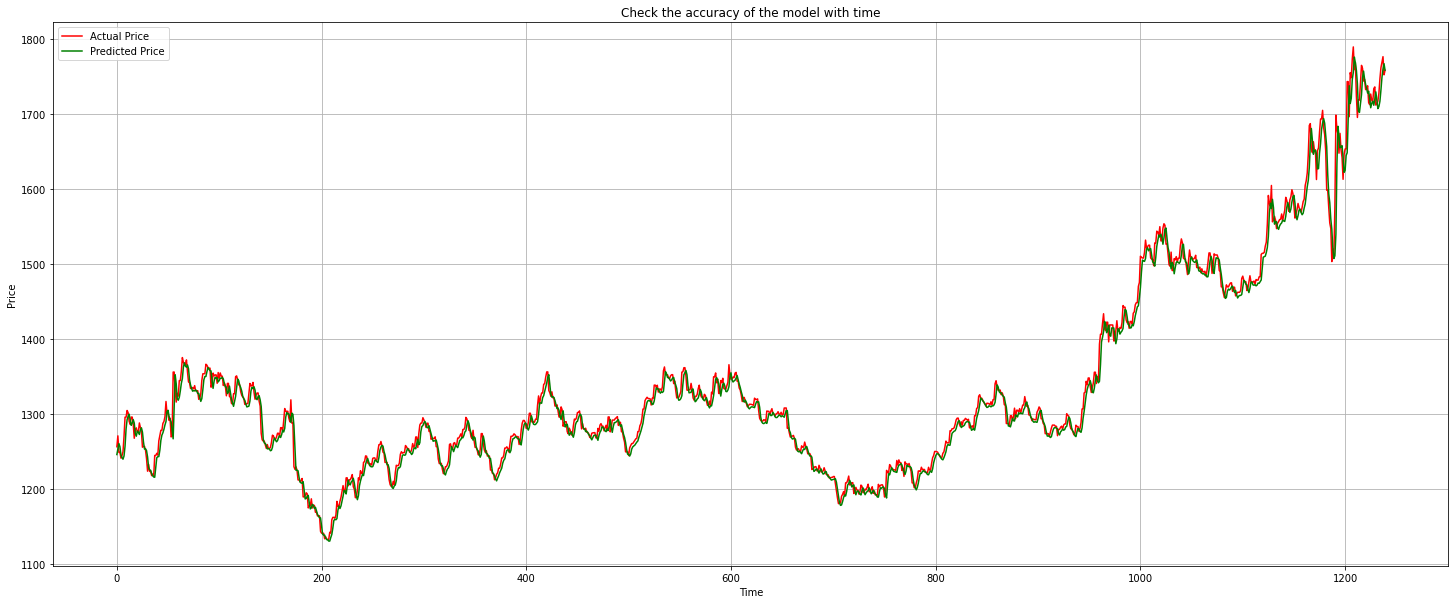

In [134]:
# The space between the predicted (red) and actual (blue) line is self explanatory for the model tuning and performance.

plt.rcParams["figure.figsize"] = (25, 10)
plt.plot(testY , 'r', label = 'Actual Price')
plt.plot(pred , 'g', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Check the accuracy of the model with time')
plt.legend()
plt.grid(True)
plt.show()

In [135]:
testY[-10 : ]

array([[1711.3   ],
       [1712.6   ],
       [1716.6   ],
       [1726.9999],
       [1746.5   ],
       [1761.1998],
       [1768.2999],
       [1775.8   ],
       [1751.6   ],
       [1757.6   ]], dtype=float32)

In [136]:
pred[-10 : ]

array([[1728.8955],
       [1717.7405],
       [1706.5919],
       [1709.2557],
       [1716.4836],
       [1731.4506],
       [1748.4226],
       [1759.1958],
       [1766.4646],
       [1757.8467]], dtype=float32)